In [1]:
import numpy as np
import torch
import pyepo

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 58.1424
0 -> 10 -> 15 -> 8 -> 5 -> 3 -> 17 -> 1 -> 6 -> 13 -> 19 -> 11 -> 18 -> 7 -> 2 -> 14 -> 12 -> 4 -> 9 -> 16 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 104.38it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 107.92it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.39it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.94it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-1, num_epochs+1)
    plt.ylim(0, 0.8)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
lr = 5e-2
num_epochs = 40
log_step = 2

In [11]:
import time
from tqdm import tqdm
from earlystop import earlyStopper

def pipeline(reg, forward_func, loss_func, lr, num_epochs, log_step, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(42)
    torch.manual_seed(42)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    # init log
    loss_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # early stop
            if stopper.stop(regret_val):
                print()
                print("Early Stop!")
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass)
            loss = forward_func(data, reg, loss_func)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # regret
    regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
    regret_log_trn.append(regret_trn)
    regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
    regret_log_val.append(regret_val)
    tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
               format(epoch, regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func):
    # unzip data
    x, _, _, t_ctr = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

### 2-Stage 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from torch import nn
# init loss
mse = nn.MSELoss()

def forward2S(data, reg, loss_func):
    # unzip data
    x, c, w, z = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, c)
    return loss

In [14]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forward2S, mse, lr, num_epochs, log_step,
                                                    loader_train_cost, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:11<?, ?it/s]

Epoch   0, Train Regret: 189.2067%, Val Regret: 187.8255%


Epoch    1, Loss:  29.4233:   5%|██▊                                                    | 2/40 [00:25<03:42,  5.85s/it]

Epoch   2, Train Regret:  21.6780%, Val Regret:  21.3671%


Epoch    3, Loss:  10.7587:  10%|█████▌                                                 | 4/40 [00:38<03:30,  5.84s/it]

Epoch   4, Train Regret:  19.2862%, Val Regret:  19.8185%


Epoch    5, Loss:  11.5214:  15%|████████▎                                              | 6/40 [00:52<03:18,  5.84s/it]

Epoch   6, Train Regret:  16.5435%, Val Regret:  17.3161%


Epoch    7, Loss:   7.2934:  20%|███████████                                            | 8/40 [01:07<03:07,  5.86s/it]

Epoch   8, Train Regret:  14.7064%, Val Regret:  15.6568%


Epoch    9, Loss:   9.6721:  25%|█████████████▌                                        | 10/40 [01:22<03:01,  6.06s/it]

Epoch  10, Train Regret:  13.5204%, Val Regret:  14.4029%


Epoch   11, Loss:   8.1704:  30%|████████████████▏                                     | 12/40 [01:36<02:56,  6.31s/it]

Epoch  12, Train Regret:  13.2665%, Val Regret:  13.5606%


Epoch   13, Loss:   8.5580:  35%|██████████████████▉                                   | 14/40 [01:50<02:37,  6.06s/it]

Epoch  14, Train Regret:  13.2572%, Val Regret:  13.4629%


Epoch   15, Loss:   6.2384:  40%|█████████████████████▌                                | 16/40 [02:04<02:22,  5.95s/it]

Epoch  16, Train Regret:  13.1845%, Val Regret:  13.6528%


Epoch   17, Loss:   7.3804:  45%|████████████████████████▎                             | 18/40 [02:17<02:10,  5.91s/it]

Epoch  18, Train Regret:  13.1734%, Val Regret:  13.6220%


Epoch   19, Loss:  13.8600:  50%|███████████████████████████                           | 20/40 [02:31<02:31,  7.56s/it]


Epoch  20, Train Regret:  13.1362%, Val Regret:  13.5462%

Early Stop!
Epoch  20, Train Regret:  13.1362%, Val Regret:  13.5462%

Evaluation:
Test Regret: 13.4760%
Training Elapsed Time: 2.01 Sec


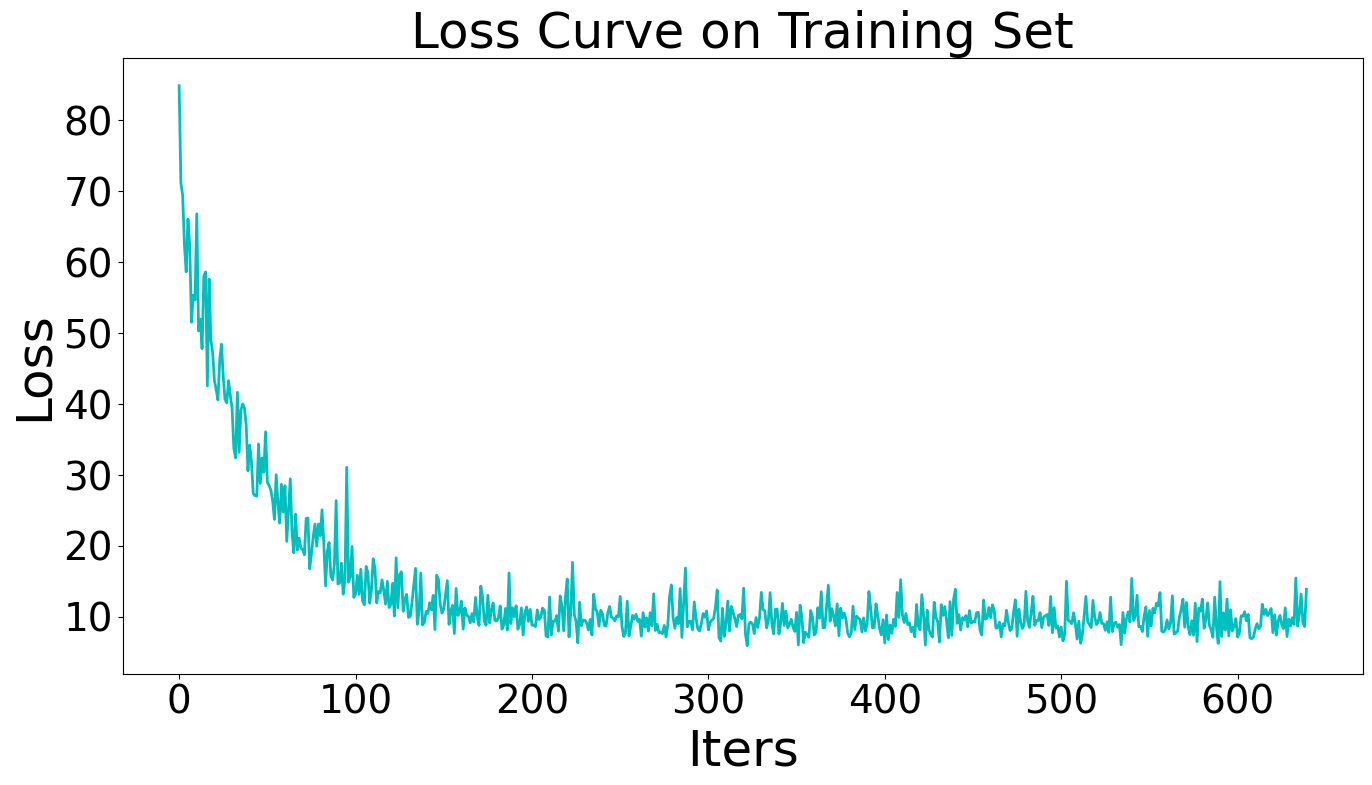

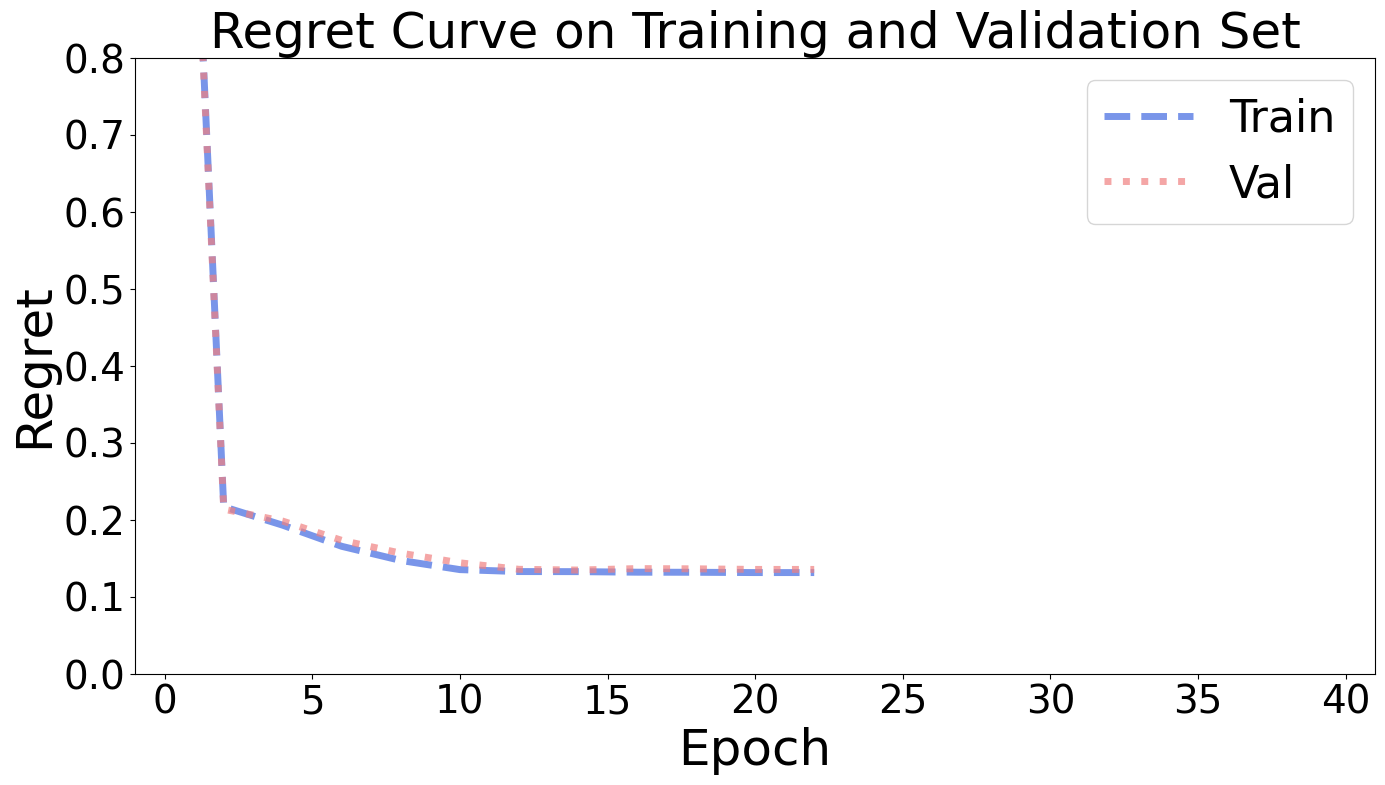

In [15]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with Clarabel

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

(CVXPY) Nov 22 09:08:42 AM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
Num of cores: 8


In [18]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:13<?, ?it/s]

Epoch   0, Train Regret: 204.0450%, Val Regret: 201.4613%


Epoch    1, Loss:  -0.9990:   5%|██▊                                                    | 2/40 [00:38<07:11, 11.35s/it]

Epoch   2, Train Regret:   8.1759%, Val Regret:   9.4004%


Epoch    3, Loss:  -0.9994:  10%|█████▌                                                 | 4/40 [00:57<05:37,  9.37s/it]

Epoch   4, Train Regret:   7.2114%, Val Regret:   8.0654%


Epoch    5, Loss:  -0.9995:  15%|████████▎                                              | 6/40 [01:16<04:59,  8.80s/it]

Epoch   6, Train Regret:   6.5245%, Val Regret:   7.8513%


Epoch    7, Loss:  -0.9993:  20%|███████████                                            | 8/40 [01:35<04:35,  8.60s/it]

Epoch   8, Train Regret:   6.6208%, Val Regret:   6.9161%


Epoch    9, Loss:  -0.9994:  25%|█████████████▌                                        | 10/40 [01:53<04:13,  8.44s/it]

Epoch  10, Train Regret:   6.8127%, Val Regret:   7.2187%


Epoch   11, Loss:  -0.9994:  30%|████████████████▏                                     | 12/40 [02:14<03:54,  8.38s/it]

Epoch  12, Train Regret:   6.8259%, Val Regret:   6.6912%


Epoch   13, Loss:  -0.9998:  35%|██████████████████▉                                   | 14/40 [02:33<03:45,  8.68s/it]

Epoch  14, Train Regret:   6.8416%, Val Regret:   6.9216%


Epoch   15, Loss:  -0.9999:  40%|█████████████████████▌                                | 16/40 [02:52<03:26,  8.59s/it]

Epoch  16, Train Regret:   7.1658%, Val Regret:   7.2670%


Epoch   17, Loss:  -0.9998:  45%|████████████████████████▎                             | 18/40 [03:11<03:53, 10.64s/it]


Epoch  18, Train Regret:   7.2675%, Val Regret:   7.8868%

Early Stop!
Epoch  18, Train Regret:   7.2675%, Val Regret:   7.8868%

Evaluation:
Test Regret: 7.8102%
Training Elapsed Time: 48.07 Sec


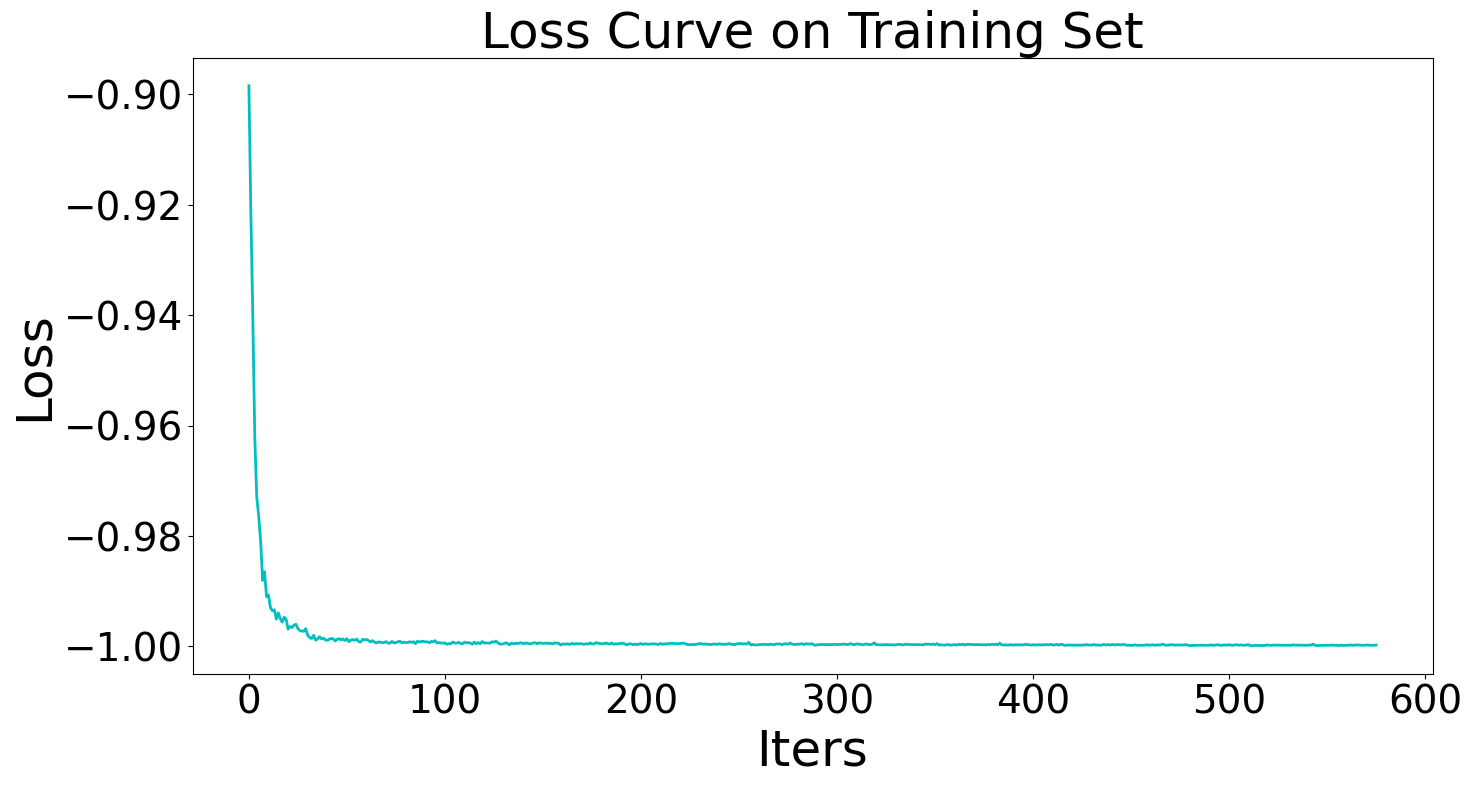

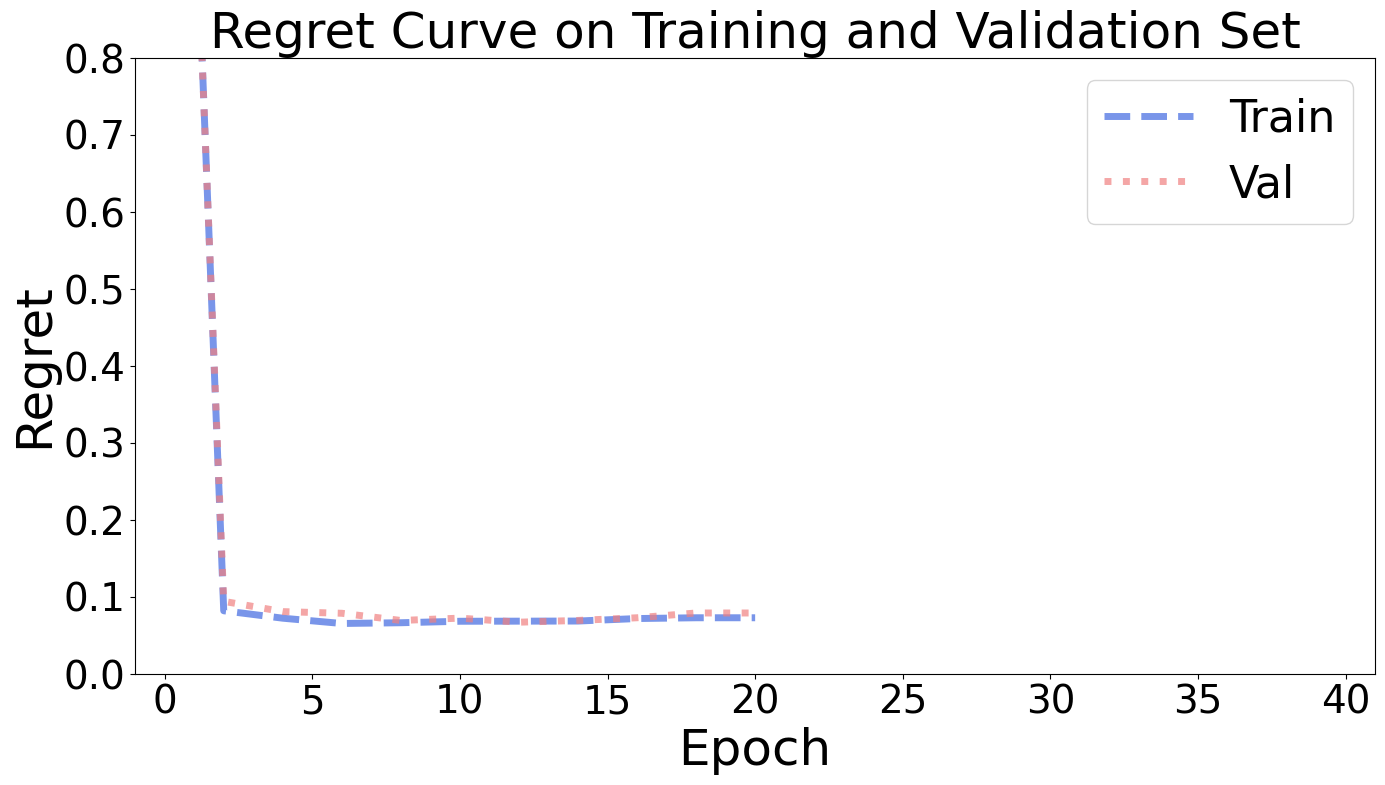

In [19]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with NNLS

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="nnls", processes=8)

Num of cores: 8


In [22]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:11<?, ?it/s]

Epoch   0, Train Regret: 186.7628%, Val Regret: 186.3438%


Epoch    1, Loss:  -0.9991:   5%|██▊                                                    | 2/40 [00:31<05:23,  8.50s/it]

Epoch   2, Train Regret:   7.9586%, Val Regret:   9.0940%


Epoch    3, Loss:  -0.9992:  10%|█████▌                                                 | 4/40 [00:53<05:17,  8.81s/it]

Epoch   4, Train Regret:   7.2410%, Val Regret:   7.5175%


Epoch    5, Loss:  -0.9994:  15%|████████▎                                              | 6/40 [01:13<05:12,  9.20s/it]

Epoch   6, Train Regret:   6.8305%, Val Regret:   7.4092%


Epoch    7, Loss:  -0.9993:  20%|███████████                                            | 8/40 [01:32<04:47,  8.97s/it]

Epoch   8, Train Regret:   6.8514%, Val Regret:   7.4618%


Epoch    9, Loss:  -0.9991:  25%|█████████████▌                                        | 10/40 [01:52<04:25,  8.87s/it]

Epoch  10, Train Regret:   6.9151%, Val Regret:   6.9062%


Epoch   11, Loss:  -0.9993:  30%|████████████████▏                                     | 12/40 [02:12<04:08,  8.86s/it]

Epoch  12, Train Regret:   6.8962%, Val Regret:   6.9798%


Epoch   13, Loss:  -0.9998:  35%|██████████████████▉                                   | 14/40 [02:32<03:49,  8.84s/it]

Epoch  14, Train Regret:   6.9587%, Val Regret:   7.2095%


Epoch   15, Loss:  -0.9998:  40%|█████████████████████▌                                | 16/40 [02:54<04:21, 10.89s/it]


Epoch  16, Train Regret:   7.1549%, Val Regret:   7.5273%

Early Stop!
Epoch  16, Train Regret:   7.1549%, Val Regret:   7.5273%

Evaluation:
Test Regret: 7.3436%
Training Elapsed Time: 43.04 Sec


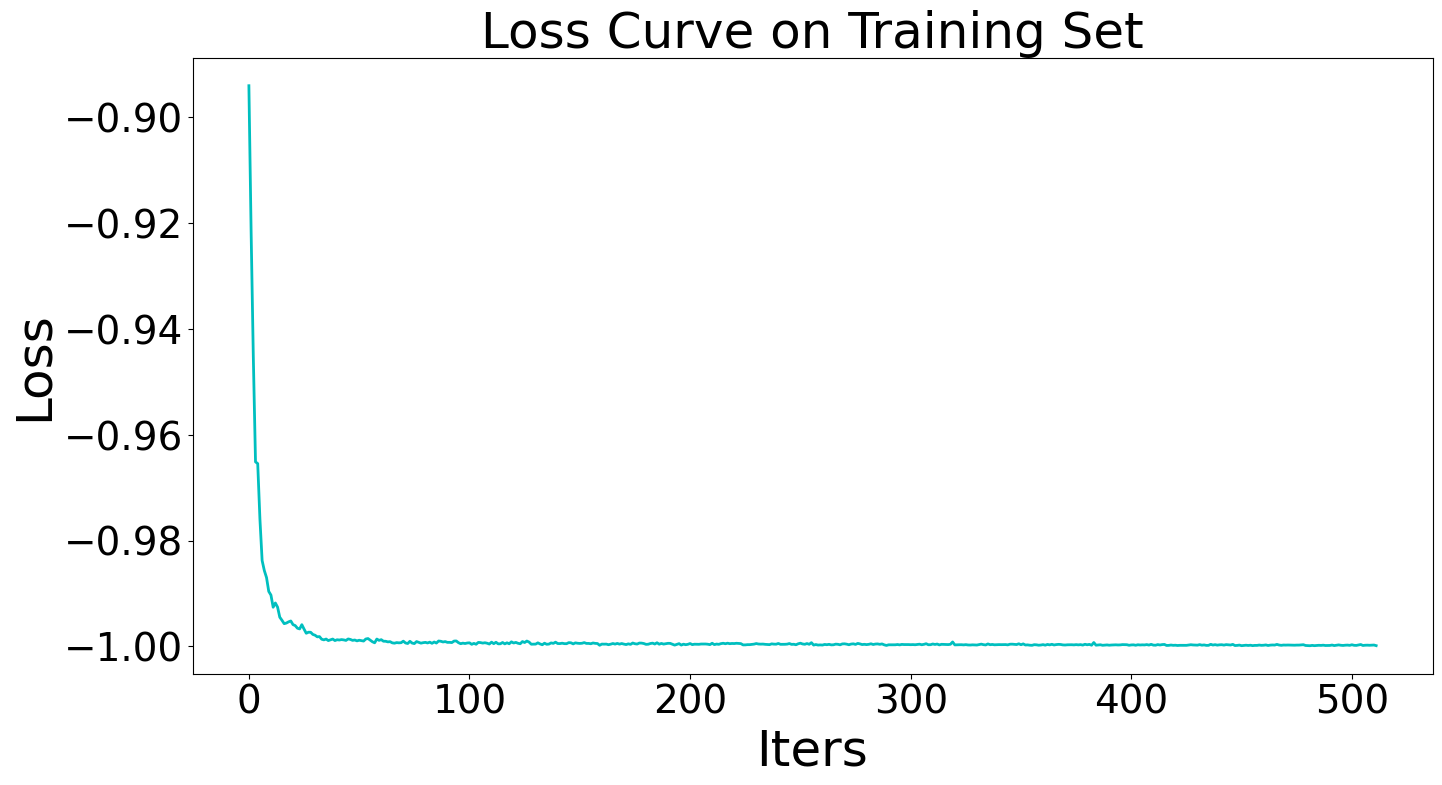

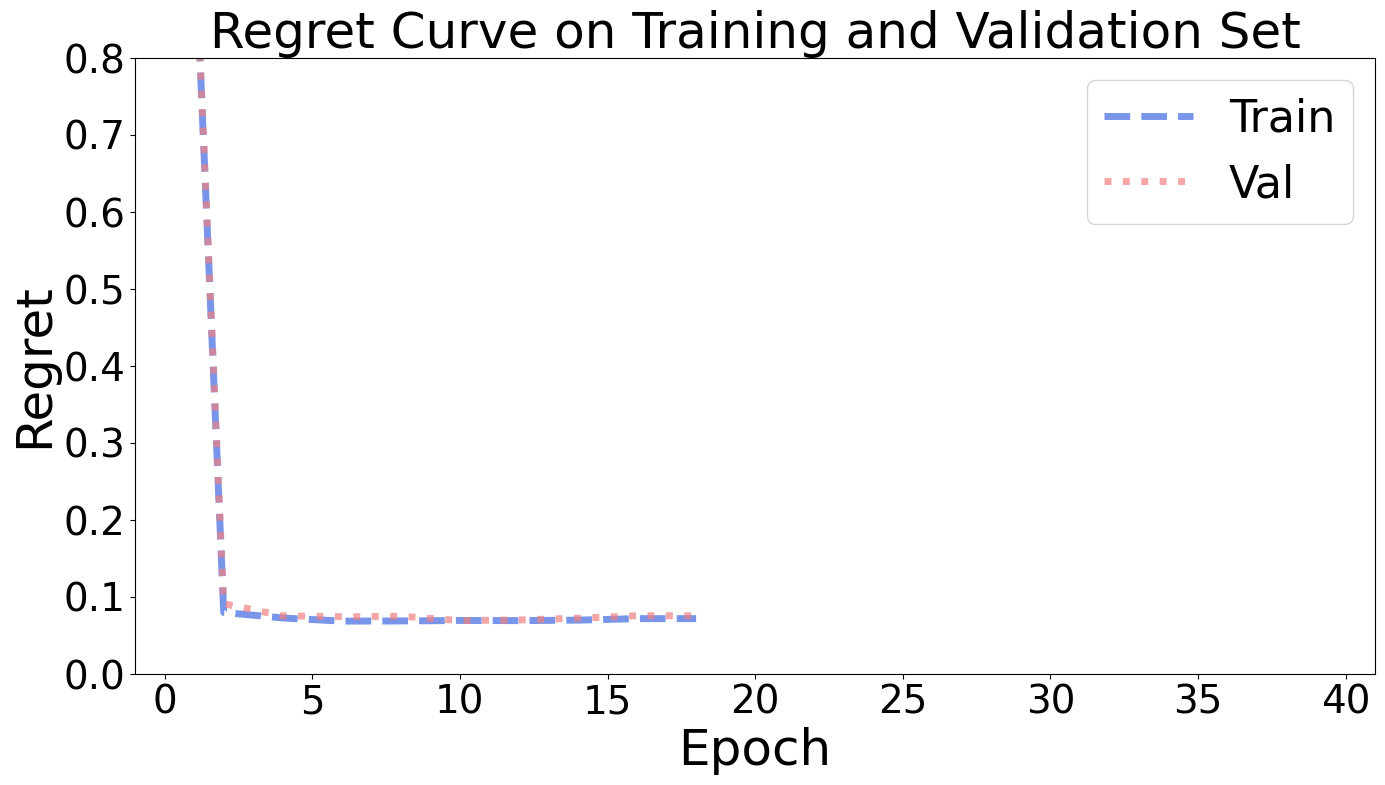

In [23]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

In [26]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:11<?, ?it/s]

Epoch   0, Train Regret: 209.0001%, Val Regret: 219.8416%


Epoch    1, Loss:  -0.7374:   5%|██▊                                                    | 2/40 [00:27<04:12,  6.66s/it]

Epoch   2, Train Regret:  15.8629%, Val Regret:  16.2837%


Epoch    3, Loss:  -0.7780:  10%|█████▌                                                 | 4/40 [00:43<04:06,  6.86s/it]

Epoch   4, Train Regret:  14.5419%, Val Regret:  15.4615%


Epoch    5, Loss:  -0.7874:  15%|████████▎                                              | 6/40 [01:00<03:56,  6.95s/it]

Epoch   6, Train Regret:  14.5683%, Val Regret:  15.6490%


Epoch    7, Loss:  -0.7264:  20%|███████████                                            | 8/40 [01:16<03:42,  6.95s/it]

Epoch   8, Train Regret:  14.8117%, Val Regret:  14.9752%


Epoch    9, Loss:  -0.7395:  25%|█████████████▌                                        | 10/40 [01:33<03:32,  7.08s/it]

Epoch  10, Train Regret:  14.3605%, Val Regret:  13.8207%


Epoch   11, Loss:  -0.7639:  30%|████████████████▏                                     | 12/40 [01:50<03:22,  7.23s/it]

Epoch  12, Train Regret:  14.4251%, Val Regret:  14.7538%


Epoch   13, Loss:  -0.7483:  35%|██████████████████▉                                   | 14/40 [02:06<03:05,  7.15s/it]

Epoch  14, Train Regret:  13.7999%, Val Regret:  13.7484%


Epoch   15, Loss:  -0.7885:  40%|█████████████████████▌                                | 16/40 [02:23<02:49,  7.06s/it]

Epoch  16, Train Regret:  14.1810%, Val Regret:  14.3354%


Epoch   17, Loss:  -0.7750:  45%|████████████████████████▎                             | 18/40 [02:40<02:37,  7.16s/it]

Epoch  18, Train Regret:  14.1609%, Val Regret:  13.4628%


Epoch   19, Loss:  -0.7735:  50%|███████████████████████████                           | 20/40 [02:56<02:26,  7.33s/it]

Epoch  20, Train Regret:  13.7216%, Val Regret:  14.5361%


Epoch   21, Loss:  -0.7210:  55%|█████████████████████████████▋                        | 22/40 [03:13<02:08,  7.16s/it]

Epoch  22, Train Regret:  13.7604%, Val Regret:  14.7531%


Epoch   23, Loss:  -0.7820:  60%|████████████████████████████████▍                     | 24/40 [03:31<02:21,  8.82s/it]


Epoch  24, Train Regret:  13.9996%, Val Regret:  13.7829%

Early Stop!
Epoch  24, Train Regret:  13.9996%, Val Regret:  13.7829%

Evaluation:
Test Regret: 14.5693%
Training Elapsed Time: 20.76 Sec


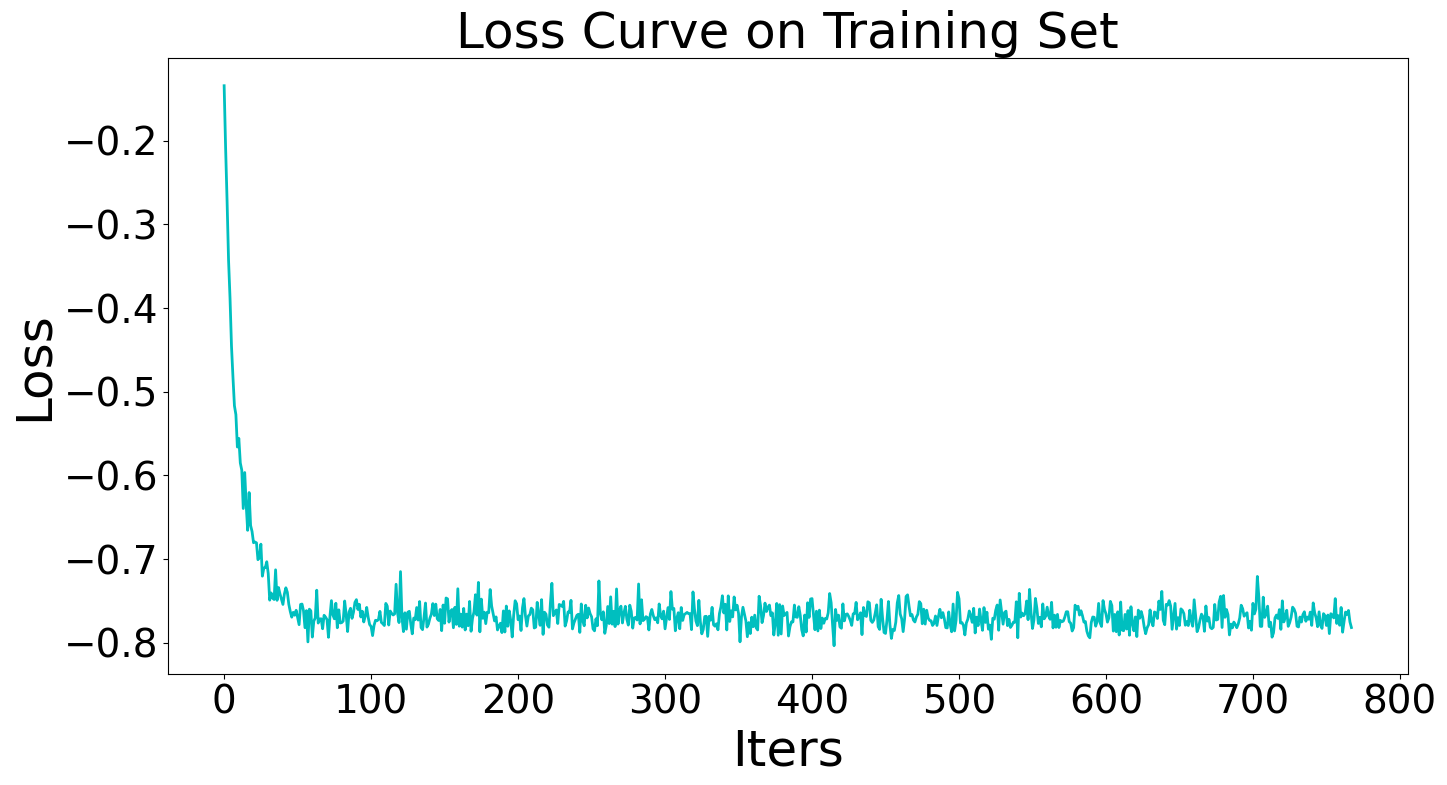

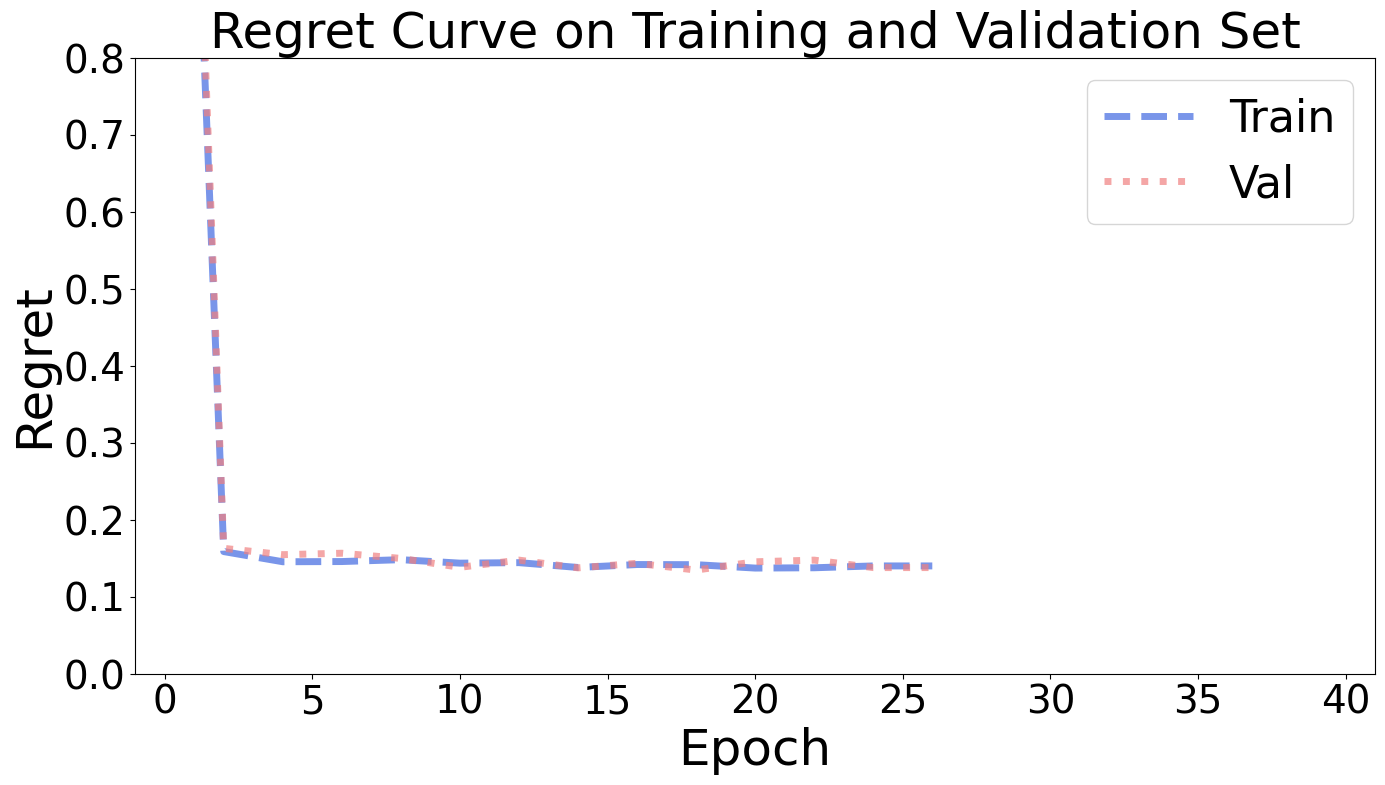

In [27]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method 

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel)

In [30]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:11<?, ?it/s]

Epoch   0, Train Regret: 192.4973%, Val Regret: 202.4173%


Epoch    1, Loss:  -0.6206:   5%|██▊                                                    | 2/40 [00:26<03:52,  6.11s/it]

Epoch   2, Train Regret:  13.5395%, Val Regret:  13.3480%


Epoch    3, Loss:  -0.7055:  10%|█████▌                                                 | 4/40 [00:41<03:45,  6.28s/it]

Epoch   4, Train Regret:  13.0569%, Val Regret:  13.8754%


Epoch    5, Loss:  -0.8116:  15%|████████▎                                              | 6/40 [00:56<03:36,  6.35s/it]

Epoch   6, Train Regret:  13.3833%, Val Regret:  13.9541%


Epoch    7, Loss:  -0.6523:  20%|███████████                                            | 8/40 [01:11<03:22,  6.34s/it]

Epoch   8, Train Regret:  13.2558%, Val Regret:  13.3161%


Epoch    9, Loss:  -0.6709:  25%|█████████████▌                                        | 10/40 [01:27<03:10,  6.34s/it]

Epoch  10, Train Regret:  12.8119%, Val Regret:  12.8347%


Epoch   11, Loss:  -0.7076:  30%|████████████████▏                                     | 12/40 [01:43<03:06,  6.66s/it]

Epoch  12, Train Regret:  13.2468%, Val Regret:  13.3407%


Epoch   13, Loss:  -0.6563:  35%|██████████████████▉                                   | 14/40 [01:58<02:52,  6.62s/it]

Epoch  14, Train Regret:  12.6046%, Val Regret:  13.4053%


Epoch   15, Loss:  -0.7895:  40%|█████████████████████▌                                | 16/40 [02:13<03:20,  8.34s/it]


Epoch  16, Train Regret:  12.9010%, Val Regret:  13.5464%

Early Stop!
Epoch  16, Train Regret:  12.9010%, Val Regret:  13.5464%

Evaluation:
Test Regret: 13.7535%
Training Elapsed Time: 3.17 Sec


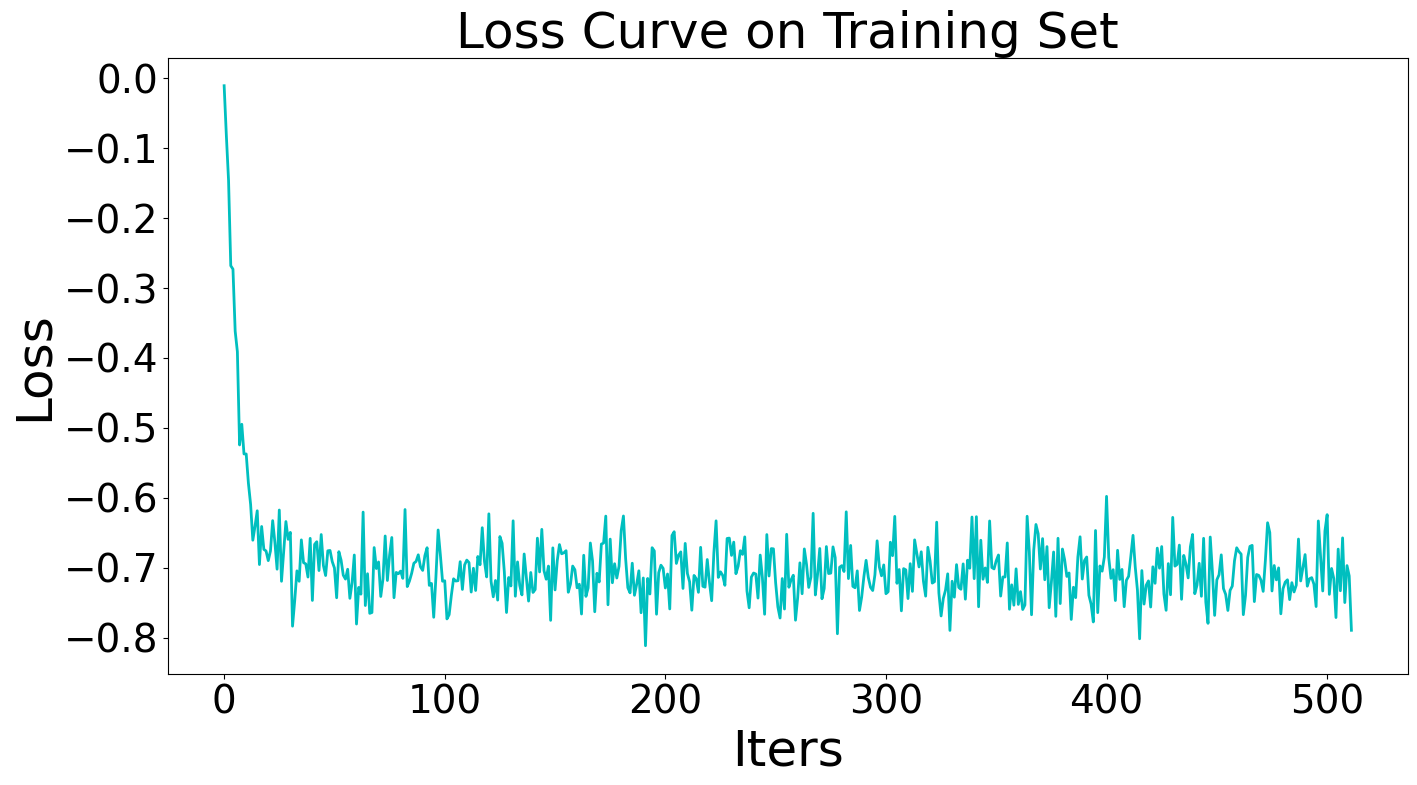

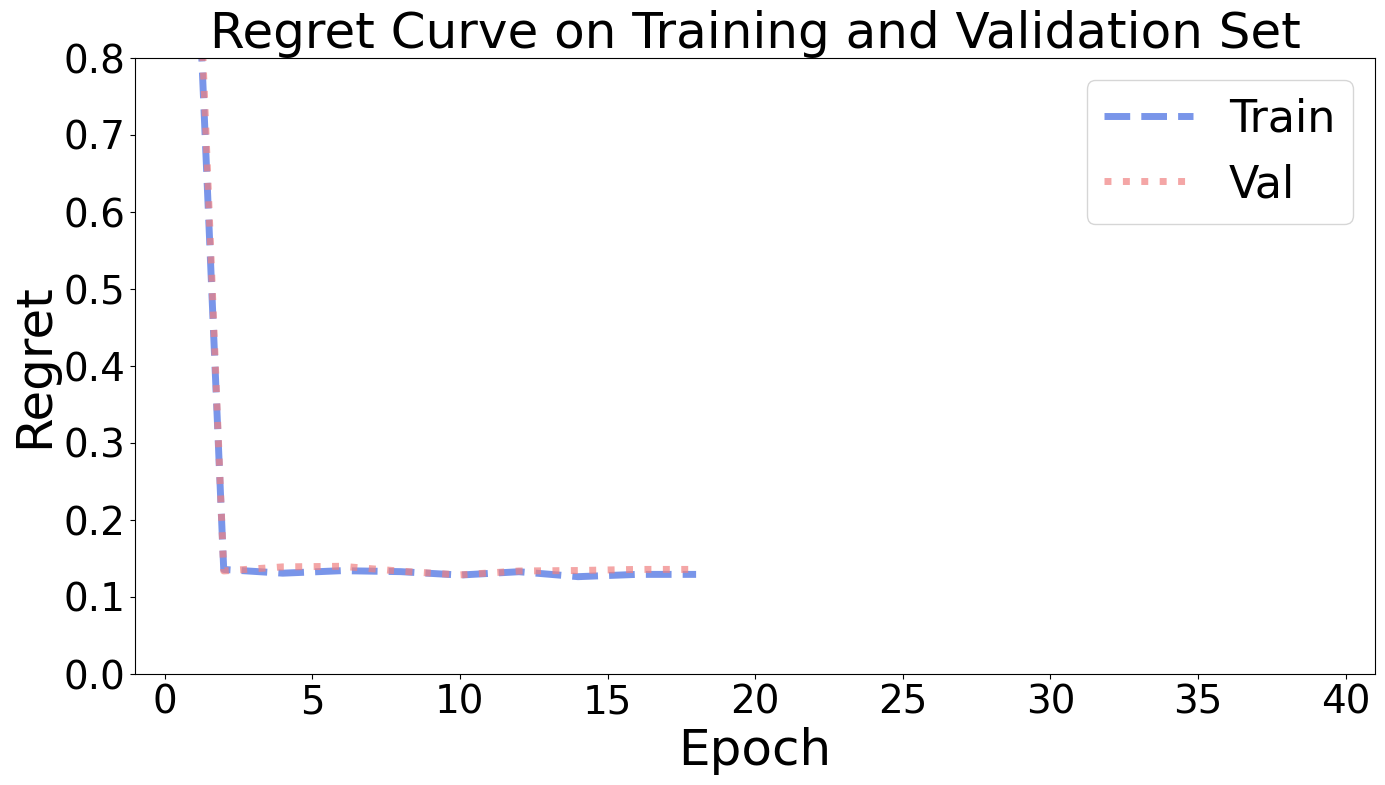

In [31]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sign Method 

In [32]:
# init model
reg = LinearRegression()

In [33]:
from func import signConeAlignedCosine
# init loss
ca_cos = signConeAlignedCosine(optmodel)

In [34]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:11<?, ?it/s]

Epoch   0, Train Regret: 209.0001%, Val Regret: 219.8416%


Epoch    1, Loss:  -0.9947:   5%|██▊                                                    | 2/40 [00:25<03:48,  6.02s/it]

Epoch   2, Train Regret:  14.7283%, Val Regret:  16.7595%


Epoch    3, Loss:  -0.9958:  10%|█████▌                                                 | 4/40 [00:40<03:37,  6.04s/it]

Epoch   4, Train Regret:  14.4649%, Val Regret:  16.5157%


Epoch    5, Loss:  -0.9967:  15%|████████▎                                              | 6/40 [00:56<03:28,  6.14s/it]

Epoch   6, Train Regret:  14.6532%, Val Regret:  14.9174%


Epoch    7, Loss:  -0.9970:  20%|███████████                                            | 8/40 [01:10<03:29,  6.56s/it]

Epoch   8, Train Regret:  16.7652%, Val Regret:  19.5855%


Epoch    9, Loss:  -0.9960:  25%|█████████████▌                                        | 10/40 [01:25<03:08,  6.30s/it]

Epoch  10, Train Regret:  18.5394%, Val Regret:  21.1669%


Epoch   11, Loss:  -0.9979:  30%|████████████████▏                                     | 12/40 [01:39<03:52,  8.32s/it]


Epoch  12, Train Regret:  24.2493%, Val Regret:  27.2965%

Early Stop!
Epoch  12, Train Regret:  24.2493%, Val Regret:  27.2965%

Evaluation:
Test Regret: 25.9594%
Training Elapsed Time: 2.46 Sec


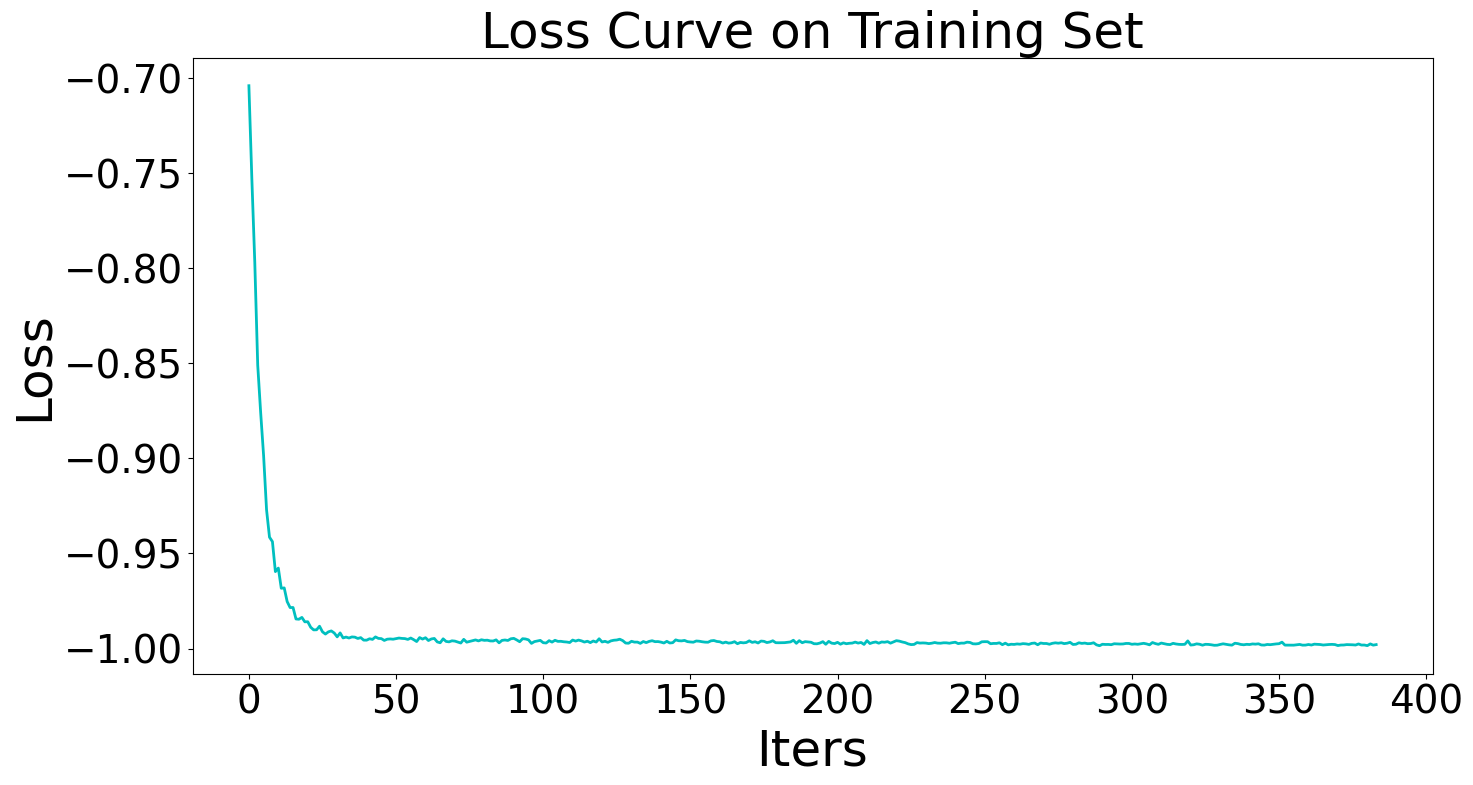

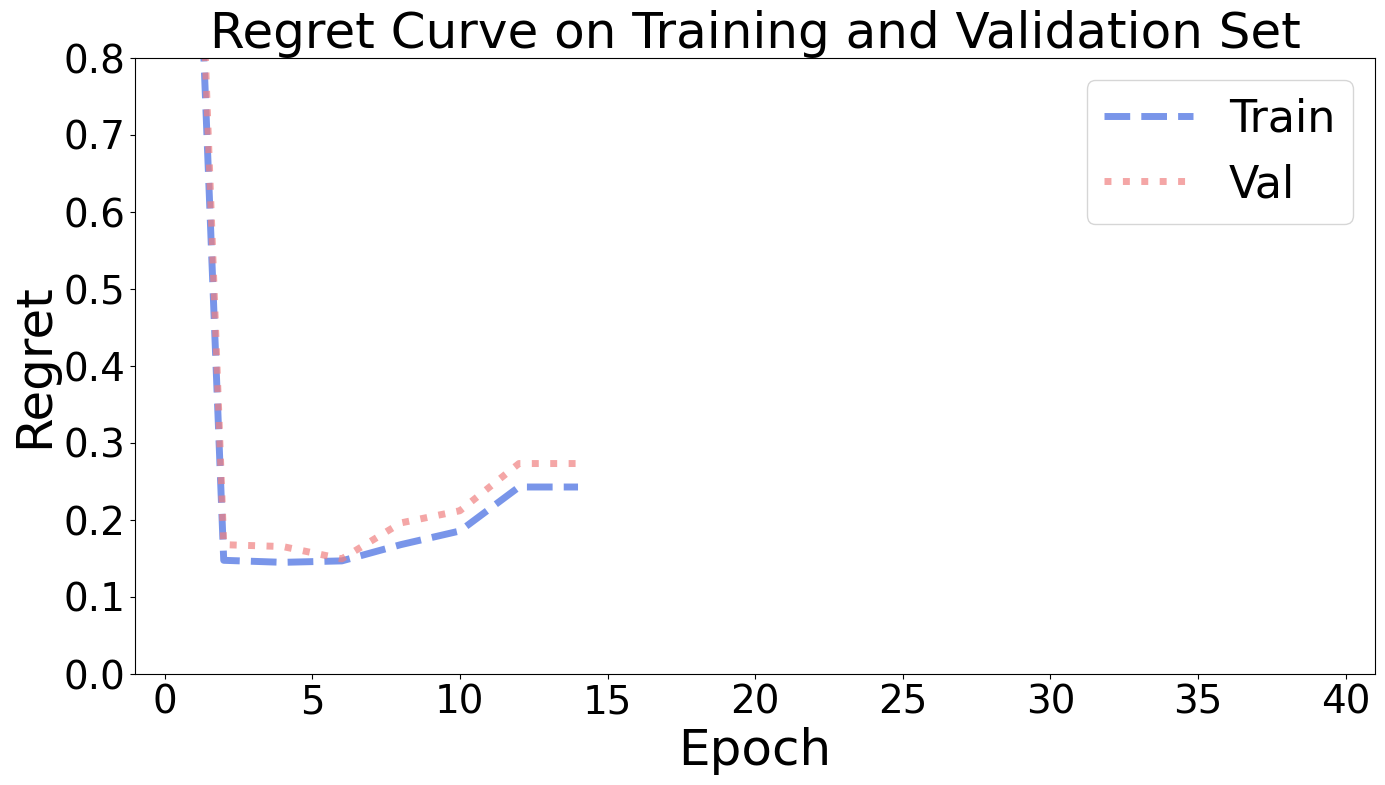

In [35]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### PFYL 

In [36]:
# init model
reg = LinearRegression()

In [37]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=1, sigma=1.0, processes=8)

def forwardPFY(data, reg, loss_func):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [38]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardPFY, pfy, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:11<?, ?it/s]

Epoch   0, Train Regret: 210.3350%, Val Regret: 211.7011%


Epoch    1, Loss:  19.5000:   5%|██▊                                                    | 2/40 [00:33<06:00,  9.48s/it]

Epoch   2, Train Regret:   6.9394%, Val Regret:   7.0811%


Epoch    3, Loss:  17.2500:  10%|█████▌                                                 | 4/40 [00:56<05:46,  9.63s/it]

Epoch   4, Train Regret:   6.2320%, Val Regret:   7.1393%


Epoch    5, Loss:  15.7500:  15%|████████▎                                              | 6/40 [01:17<05:39,  9.98s/it]

Epoch   6, Train Regret:   6.1828%, Val Regret:   6.9675%


Epoch    7, Loss:  16.0000:  20%|███████████                                            | 8/40 [01:39<05:18,  9.96s/it]

Epoch   8, Train Regret:   6.0266%, Val Regret:   7.1028%


Epoch    9, Loss:  15.7500:  25%|█████████████▌                                        | 10/40 [02:00<04:52,  9.74s/it]

Epoch  10, Train Regret:   5.8728%, Val Regret:   6.6177%


Epoch   11, Loss:  15.7500:  30%|████████████████▏                                     | 12/40 [02:22<04:28,  9.60s/it]

Epoch  12, Train Regret:   5.8402%, Val Regret:   6.5720%


Epoch   13, Loss:  15.0000:  35%|██████████████████▉                                   | 14/40 [02:44<04:10,  9.62s/it]

Epoch  14, Train Regret:   5.5439%, Val Regret:   7.0739%


Epoch   15, Loss:  13.7500:  40%|█████████████████████▌                                | 16/40 [03:06<03:57,  9.89s/it]

Epoch  16, Train Regret:   5.8180%, Val Regret:   5.7484%


Epoch   17, Loss:  14.0000:  45%|████████████████████████▎                             | 18/40 [03:27<03:36,  9.84s/it]

Epoch  18, Train Regret:   5.6705%, Val Regret:   6.1145%


Epoch   19, Loss:  11.0000:  50%|███████████████████████████                           | 20/40 [03:49<03:14,  9.73s/it]

Epoch  20, Train Regret:   5.6642%, Val Regret:   6.3114%


Epoch   21, Loss:  16.0000:  55%|█████████████████████████████▋                        | 22/40 [04:11<03:25, 11.42s/it]


Epoch  22, Train Regret:   5.9320%, Val Regret:   6.5171%

Early Stop!
Epoch  22, Train Regret:   5.9320%, Val Regret:   6.5171%

Evaluation:
Test Regret: 6.6252%
Training Elapsed Time: 80.60 Sec


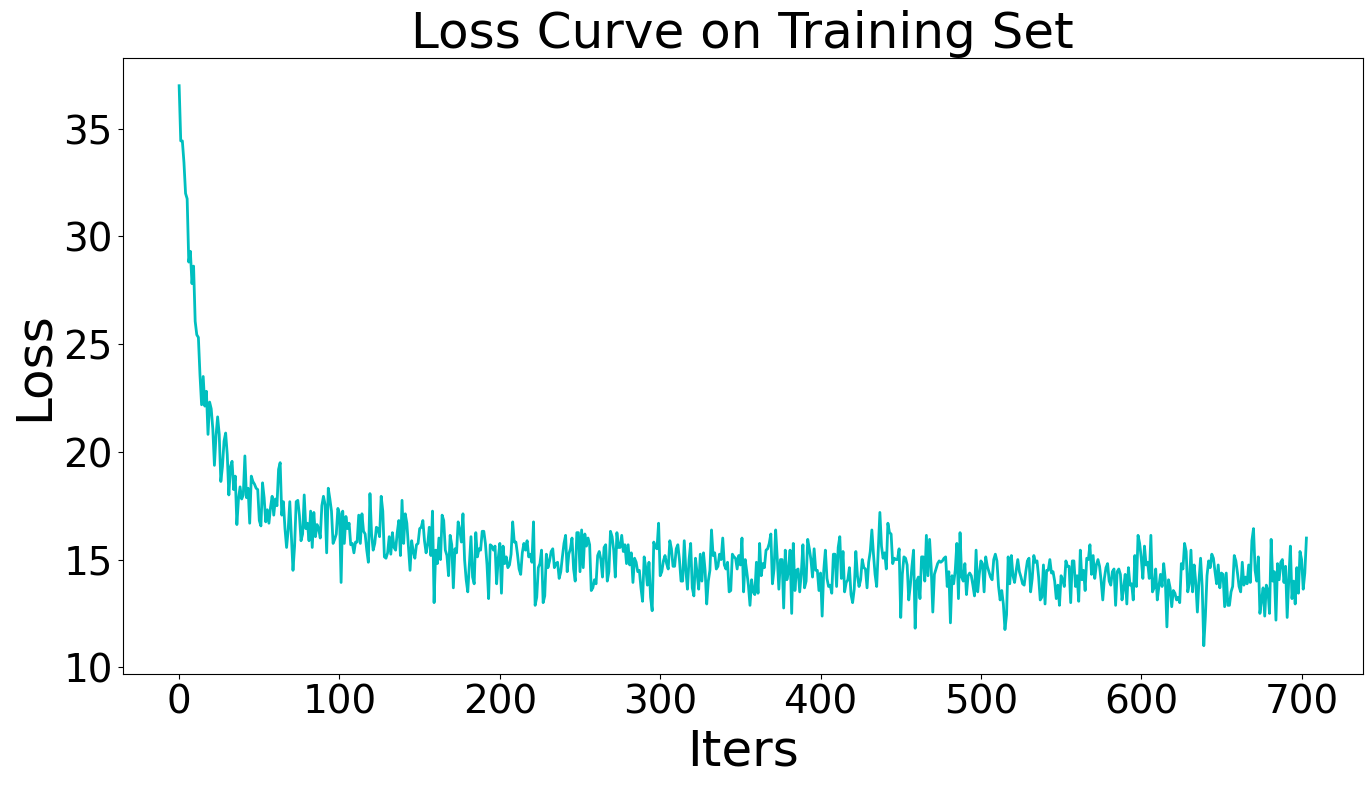

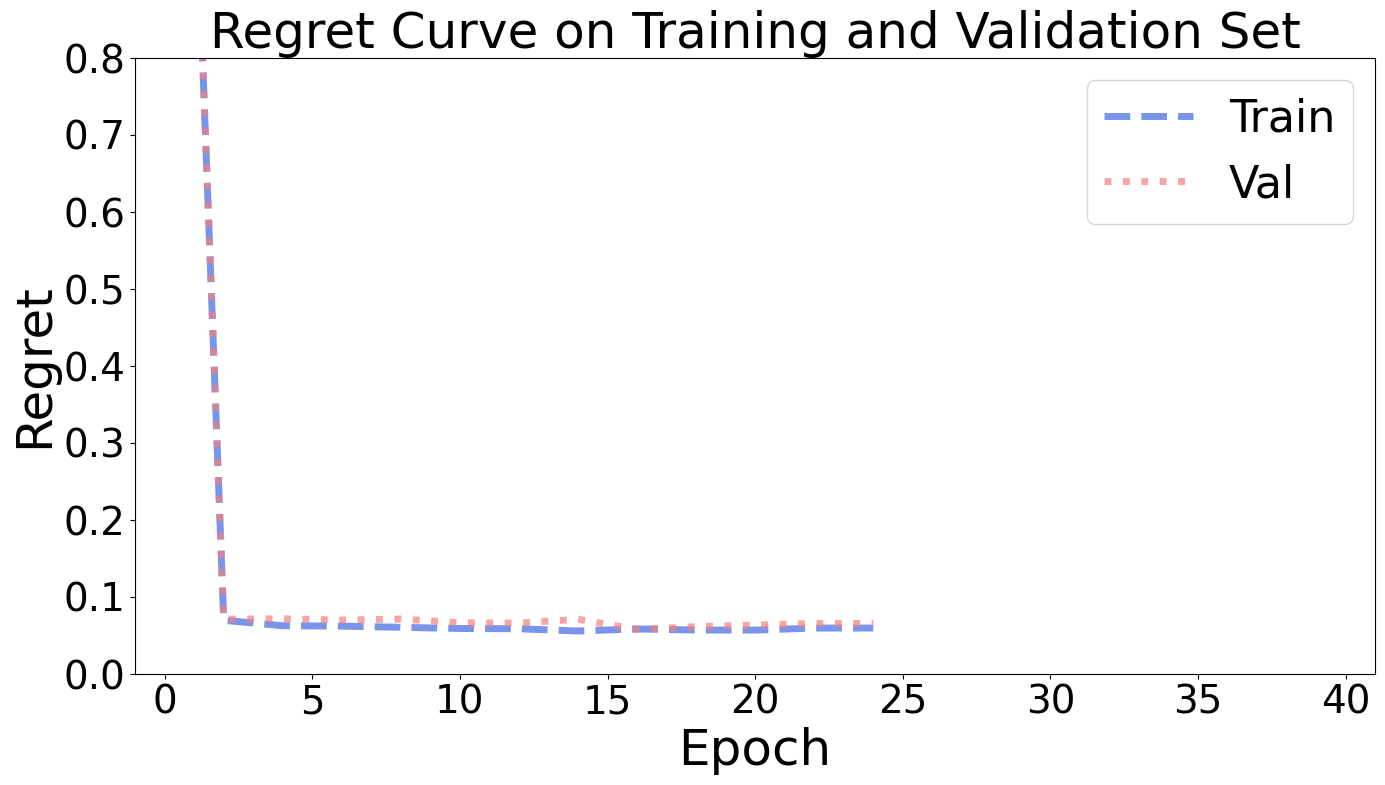

In [39]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NCE 

In [40]:
# init model
reg = LinearRegression()

In [41]:
from pyepo.func import NCE
# init nce loss
nce = NCE(optmodel, processes=8, solve_ratio=0.05, dataset=dataset_train_cost)

def forwardNCE(data, reg, loss_func):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [42]:
loss_log, regret_log_trn, regret_log_val = pipeline(reg, forwardNCE, nce, lr, num_epochs, log_step,
                                                    loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:14<?, ?it/s]

Epoch   0, Train Regret: 217.4985%, Val Regret: 224.1207%


Epoch    1, Loss: -118.0295:   5%|██▋                                                   | 2/40 [00:29<04:40,  7.37s/it]

Epoch   2, Train Regret:  15.1573%, Val Regret:  16.7521%


Epoch    3, Loss: -243.9377:  10%|█████▍                                                | 4/40 [00:44<04:02,  6.72s/it]

Epoch   4, Train Regret:  13.4023%, Val Regret:  14.7209%


Epoch    5, Loss: -486.7506:  15%|████████                                              | 6/40 [00:59<03:44,  6.61s/it]

Epoch   6, Train Regret:  12.8023%, Val Regret:  14.8994%


Epoch    7, Loss: -492.1599:  20%|██████████▊                                           | 8/40 [01:13<03:26,  6.46s/it]

Epoch   8, Train Regret:  12.3584%, Val Regret:  14.3723%


Epoch    9, Loss: -613.8723:  25%|█████████████▎                                       | 10/40 [01:28<03:11,  6.39s/it]

Epoch  10, Train Regret:  12.0321%, Val Regret:  13.9495%


Epoch   11, Loss: -755.9453:  30%|███████████████▉                                     | 12/40 [01:44<03:02,  6.53s/it]

Epoch  12, Train Regret:  11.7726%, Val Regret:  13.6017%


Epoch   13, Loss: -1020.5058:  35%|██████████████████▏                                 | 14/40 [01:58<02:44,  6.33s/it]

Epoch  14, Train Regret:  11.4636%, Val Regret:  13.3322%


Epoch   15, Loss: -1010.1003:  40%|████████████████████▊                               | 16/40 [02:15<02:31,  6.32s/it]

Epoch  16, Train Regret:  11.2536%, Val Regret:  13.2268%


Epoch   17, Loss: -1176.4634:  45%|███████████████████████▍                            | 18/40 [02:30<02:28,  6.75s/it]

Epoch  18, Train Regret:  11.1167%, Val Regret:  12.9119%


Epoch   19, Loss: -1431.1914:  50%|██████████████████████████                          | 20/40 [02:44<02:11,  6.57s/it]

Epoch  20, Train Regret:  10.9138%, Val Regret:  12.4774%


Epoch   21, Loss: -1386.6636:  55%|████████████████████████████▌                       | 22/40 [02:59<01:54,  6.34s/it]

Epoch  22, Train Regret:  10.8073%, Val Regret:  12.6236%


Epoch   23, Loss: -1359.8947:  60%|███████████████████████████████▏                    | 24/40 [03:13<01:40,  6.28s/it]

Epoch  24, Train Regret:  10.7812%, Val Regret:  12.5102%


Epoch   25, Loss: -1895.4957:  65%|█████████████████████████████████▊                  | 26/40 [03:28<01:28,  6.31s/it]

Epoch  26, Train Regret:  10.7910%, Val Regret:  12.2196%


Epoch   27, Loss: -1976.8257:  70%|████████████████████████████████████▍               | 28/40 [03:43<01:16,  6.40s/it]

Epoch  28, Train Regret:  10.7560%, Val Regret:  12.2343%


Epoch   29, Loss: -2062.4336:  75%|███████████████████████████████████████             | 30/40 [03:58<01:04,  6.44s/it]

Epoch  30, Train Regret:  10.7130%, Val Regret:  12.1141%


Epoch   31, Loss: -1764.5477:  80%|█████████████████████████████████████████▌          | 32/40 [04:15<00:50,  6.36s/it]

Epoch  32, Train Regret:  10.7320%, Val Regret:  12.1141%


Epoch   33, Loss: -2348.6804:  85%|████████████████████████████████████████████▏       | 34/40 [04:31<00:41,  6.94s/it]

Epoch  34, Train Regret:  10.7254%, Val Regret:  12.0652%


Epoch   35, Loss: -2186.2241:  90%|██████████████████████████████████████████████▊     | 36/40 [04:45<00:26,  6.57s/it]

Epoch  36, Train Regret:  10.7229%, Val Regret:  12.0470%


Epoch   37, Loss: -2283.8281:  95%|█████████████████████████████████████████████████▍  | 38/40 [05:00<00:13,  6.58s/it]

Epoch  38, Train Regret:  10.6746%, Val Regret:  12.0124%


Epoch   39, Loss: -2860.1089: 100%|████████████████████████████████████████████████████| 40/40 [05:03<00:00,  7.59s/it]


Epoch  39, Train Regret:  10.6739%, Val Regret:  12.0470%

Evaluation:
Test Regret: 11.4366%
Training Elapsed Time: 18.66 Sec


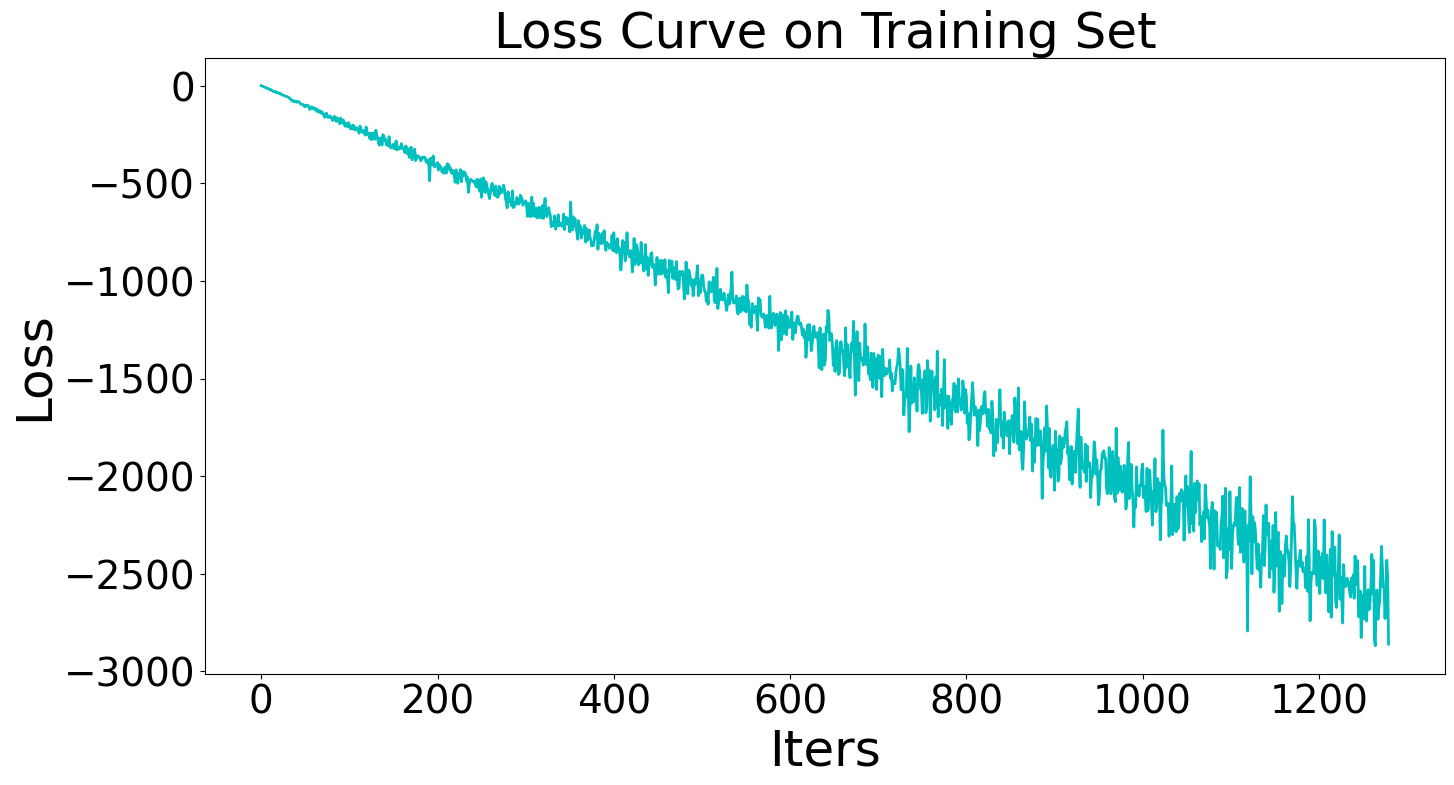

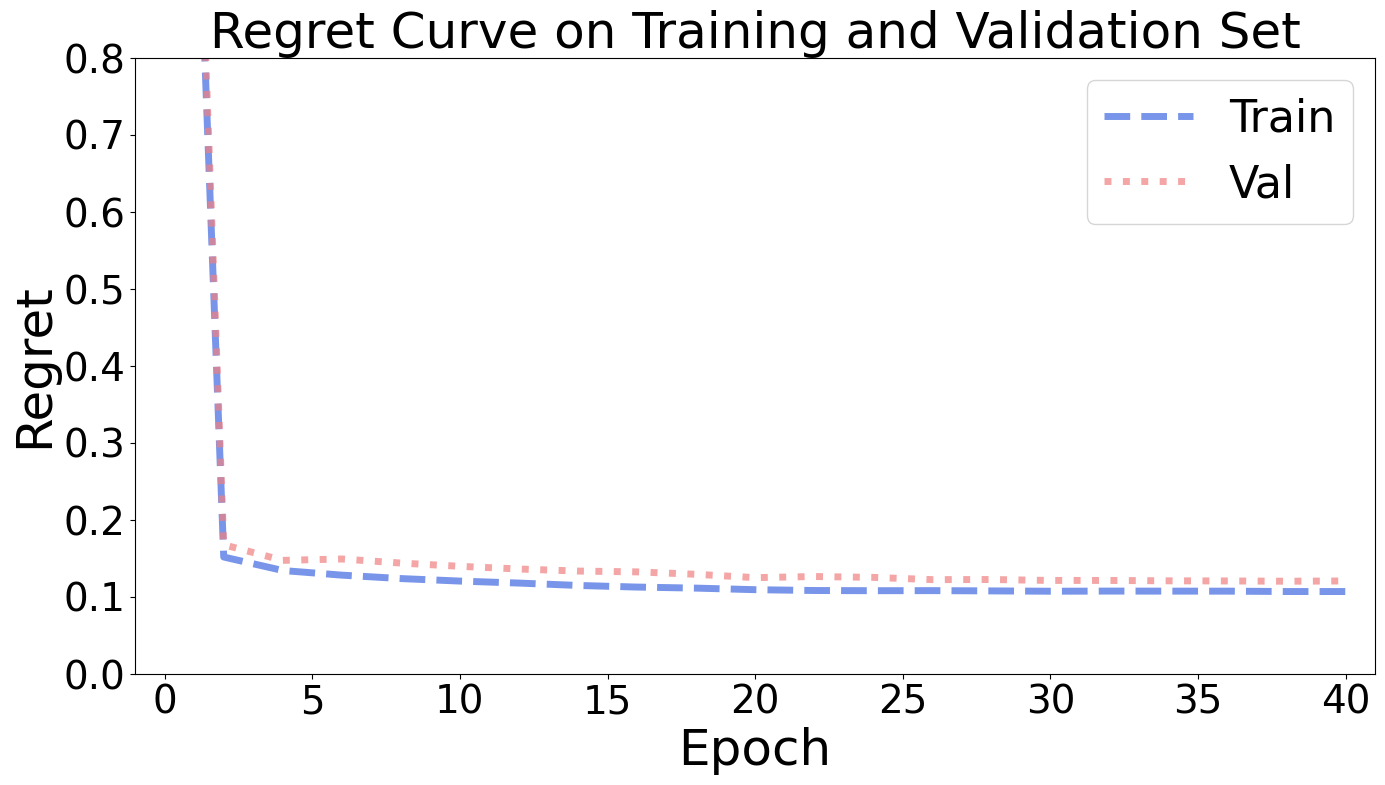

In [43]:
plot(loss_log, regret_log_trn, regret_log_val, num_epochs, log_step)